# 211016 Basic Plots

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import h5py as h5
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Setup

In [4]:
DATESTR = '211016'
NBNAME = DATESTR + '-basic-plots'

In [5]:
infiles = dict(
    genomes=Path('data-processed/211015-combine-data/211015-gambit-ani-genomes.csv'),
    data=Path('data-intermediate/211015-combine-data/data.nc'),
    assembly_stats=Path('data-processed/211016-additional-genome-stats/211016-assembly-stats.csv'),
)

In [6]:
outfiles = dict(
    gambit_ani_scatter=f'reports/{DATESTR}-gambit-vs-ani.png',
    gambit_ani_spearman=f'reports/{DATESTR}-gambit-ani-spearman.png',
)

## Code

In [7]:
def get_datasets(group):
    return {name: child[:] for name, child in group.items()}

## Load data

### Genomes

In [8]:
genomes = pd.read_csv(infiles['genomes'], index_col=[0, 1])

In [9]:
_stats = pd.read_csv(infiles['assembly_stats'], index_col=[0, 1])
genomes = pd.concat([genomes, _stats], axis=1)

### Common

In [10]:
common_ds = xr.load_dataset(infiles['data'], group='common')

common_df = common_ds.to_dataframe(['data_set', 'param'])

In [11]:
gsets = common_ds.indexes['data_set']
ngsets = len(gsets)

### Params

In [12]:
params_df = common_ds \
    .drop_dims('data_set') \
    .to_dataframe() \
    .set_index(['prefix_len', 'prefix_version', 'k'], drop=True)

In [13]:
def get_param(prefix_len, prefix_version, k):
    return params_df.index.get_loc((prefix_len, prefix_version, k))

In [14]:
gambitdb_param = get_param(5, 0, 11)

### By genome

In [15]:
genome_dss = {gset: xr.load_dataset(infiles['data'], group='genome/' + gset) for gset in gsets}

## Plots

### Gambit vs ANI

In [16]:
best_spearman = common_ds['ani_spearman'].argmax(dim='param').to_series().to_dict()

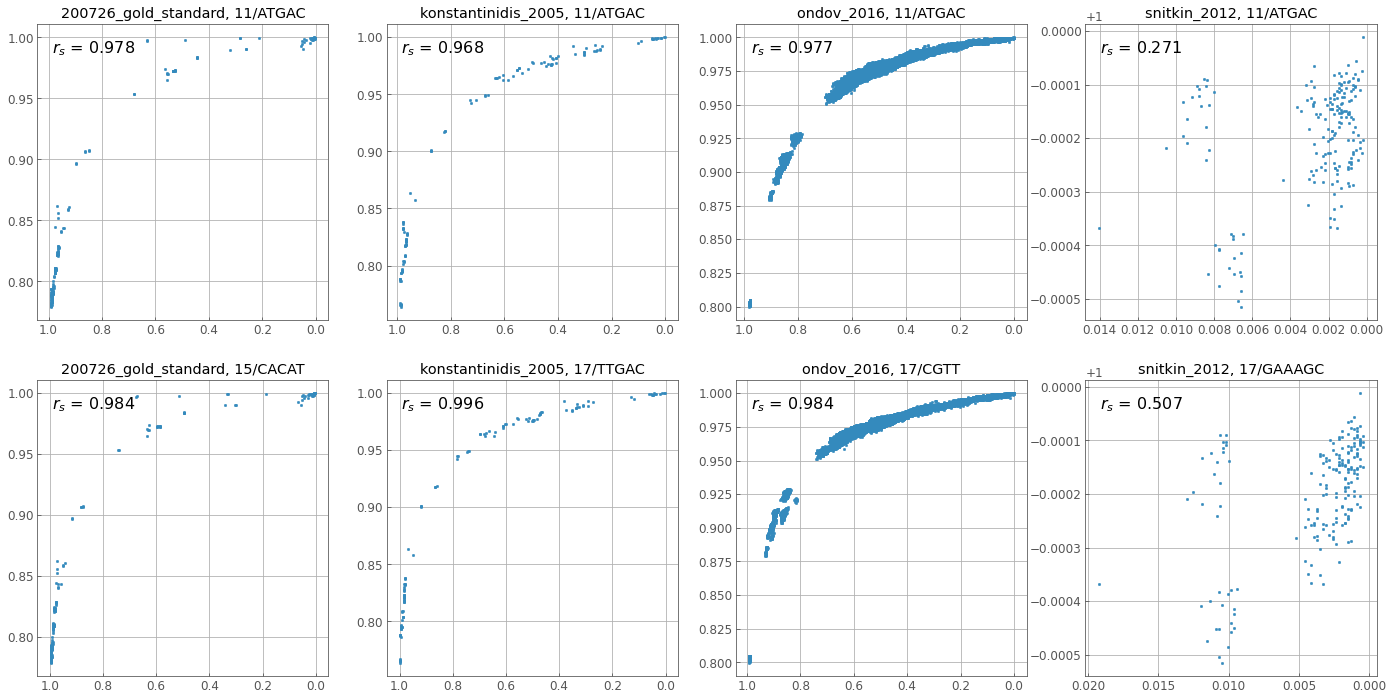

In [17]:
fig, axs = plt.subplots(2, ngsets, figsize=(24, 12))

for i, gset in enumerate(gsets):
    ds = genome_dss[gset]
    mask = ds['corr_mask']
    
    for j, param in enumerate([gambitdb_param, best_spearman[gset]]):
        ax = axs[j, i]
        ds2 = ds.sel(param=param)

        ax.scatter(
            x=ds2['dist'][mask],
            y=ds2['ani_mean'][mask],
            s=6,
        )
        
        cds2 = common_ds.sel(param=param, data_set=gset)
        k = cds2['k'].item()
        prefix = cds2['prefix'].item()
        r_s = cds2['ani_spearman'].item()

        ax.invert_xaxis()
        ax.set_title(f'{gset}, {k}/{prefix}')
        ax.text(
            .05, .95,
            f'$r_s$ = {r_s:.3f}',
            ha='left',
            va='top',
            fontsize=16,
            transform=ax.transAxes,
        )
        
plt.savefig(outfiles['gambit_ani_scatter'])

### Spearman correlation

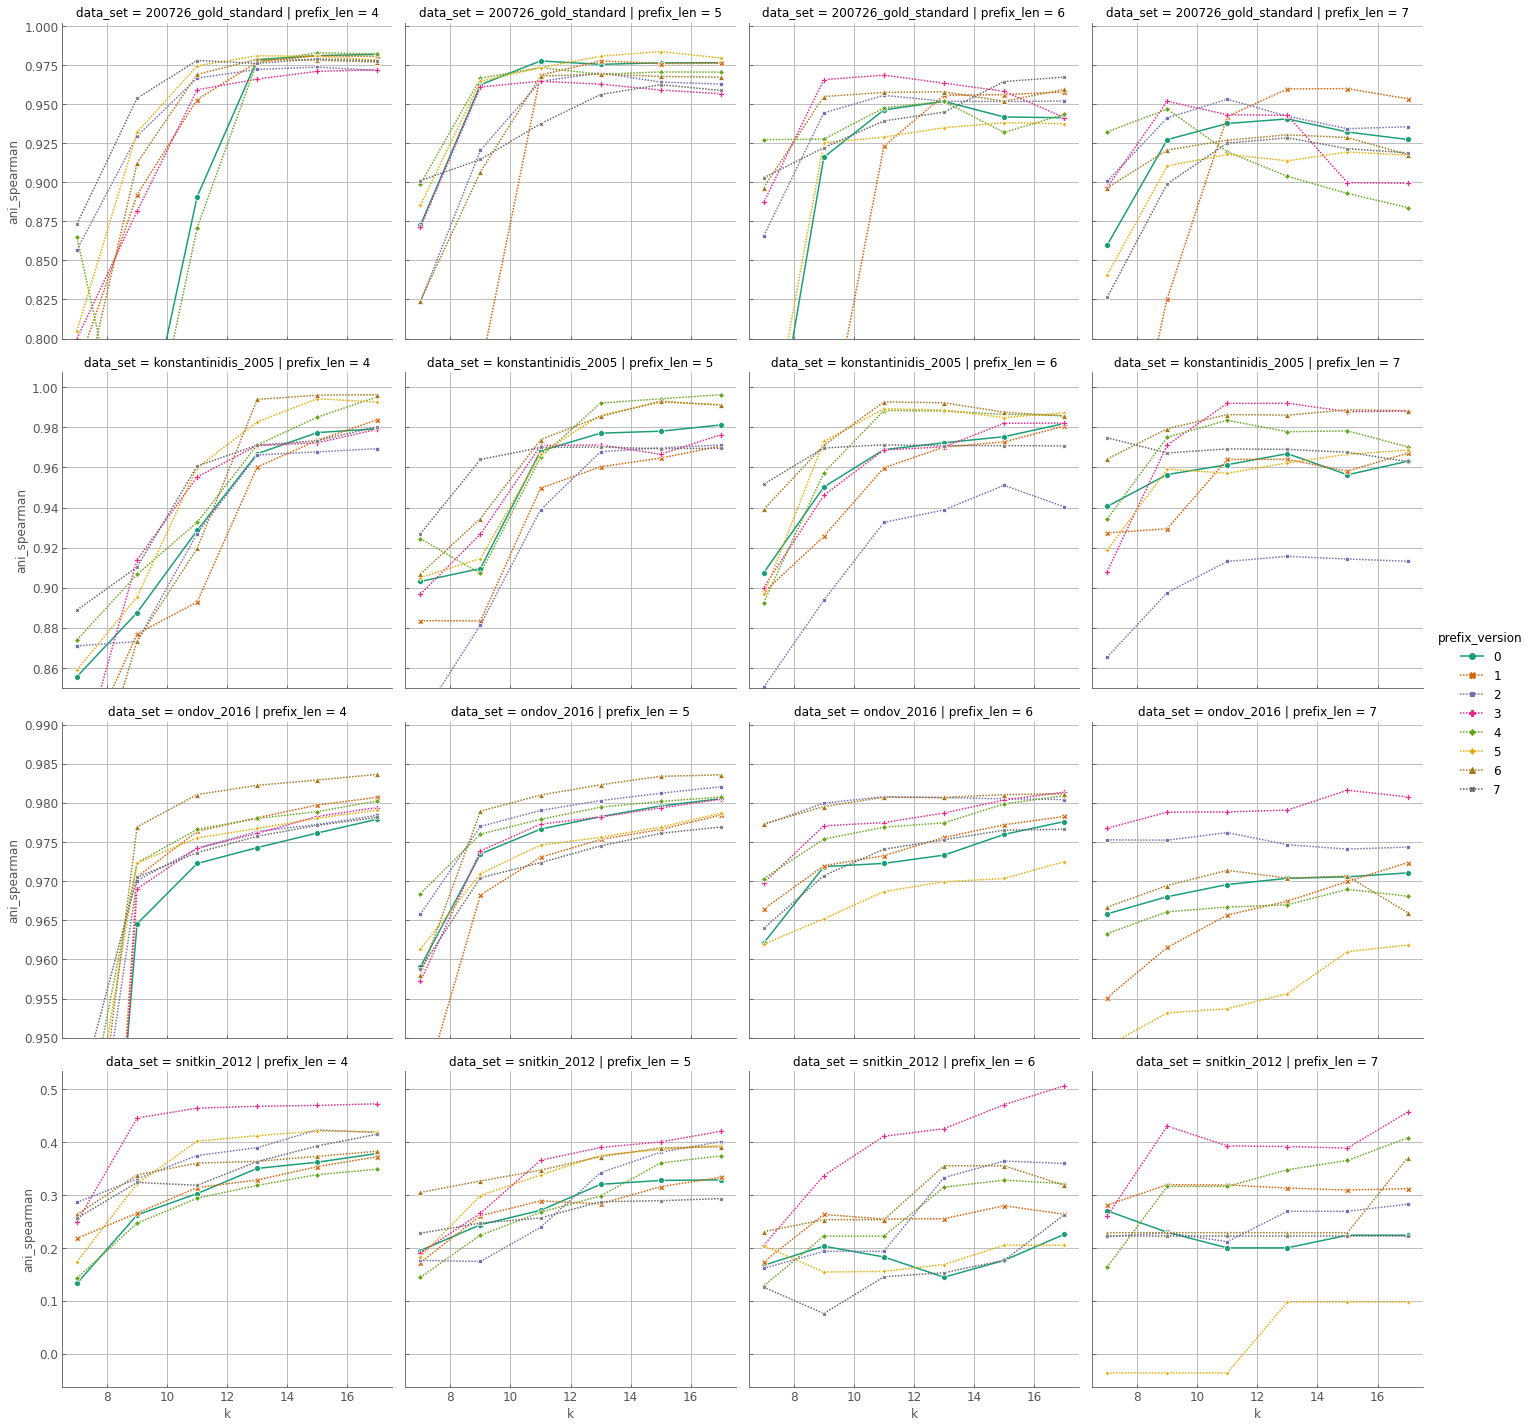

In [18]:
fg = sns.relplot(
    kind='line',
    data=common_df.reset_index(),
    x='k',
    y='ani_spearman',
    col='prefix_len',
    row='data_set',
    hue='prefix_version',
    style='prefix_version',
    dashes=dict(enumerate([(1, 0)] + [(1, 1)] * 7)),
    markers=True,
    facet_kws=dict(sharey='row'),
    palette='Dark2',
    height=5,
)


fg.axes_dict['200726_gold_standard', 4].set_ylim([.8, None])
fg.axes_dict['ondov_2016', 4].set_ylim([.95, None])
fg.axes_dict['konstantinidis_2005', 4].set_ylim([.85, None])
        
plt.savefig(outfiles['gambit_ani_spearman'])

## Compare correlation methods

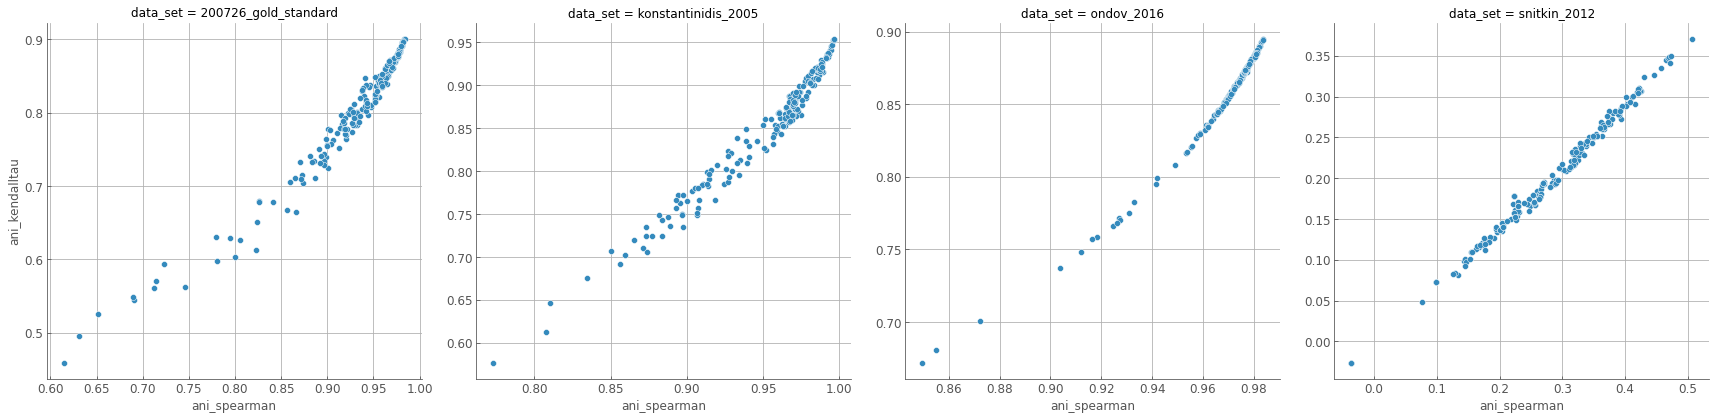

In [19]:
sns.relplot(
    data=common_df.reset_index(),
    x='ani_spearman',
    y='ani_kendalltau',
    col='data_set',
    facet_kws=dict(sharex=False, sharey=False),
    height=6,
)

## Assembly statistics

In [20]:
for col in ['size', 'ncontigs', 'n50', 'l50']:
    genomes['log_' + col] = np.log10(genomes[col])

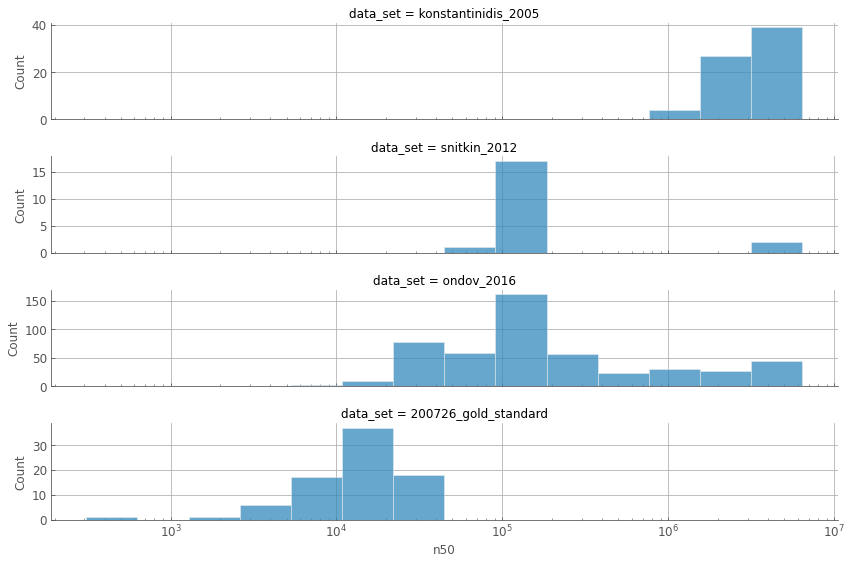

In [21]:
sns.displot(
    data=genomes.reset_index(),
    x='n50',
#     hue='data_set',
    row='data_set',
#     stat='probability',
    height=2,
    aspect=6,
    log_scale=True,
    facet_kws=dict(sharey=False),
)

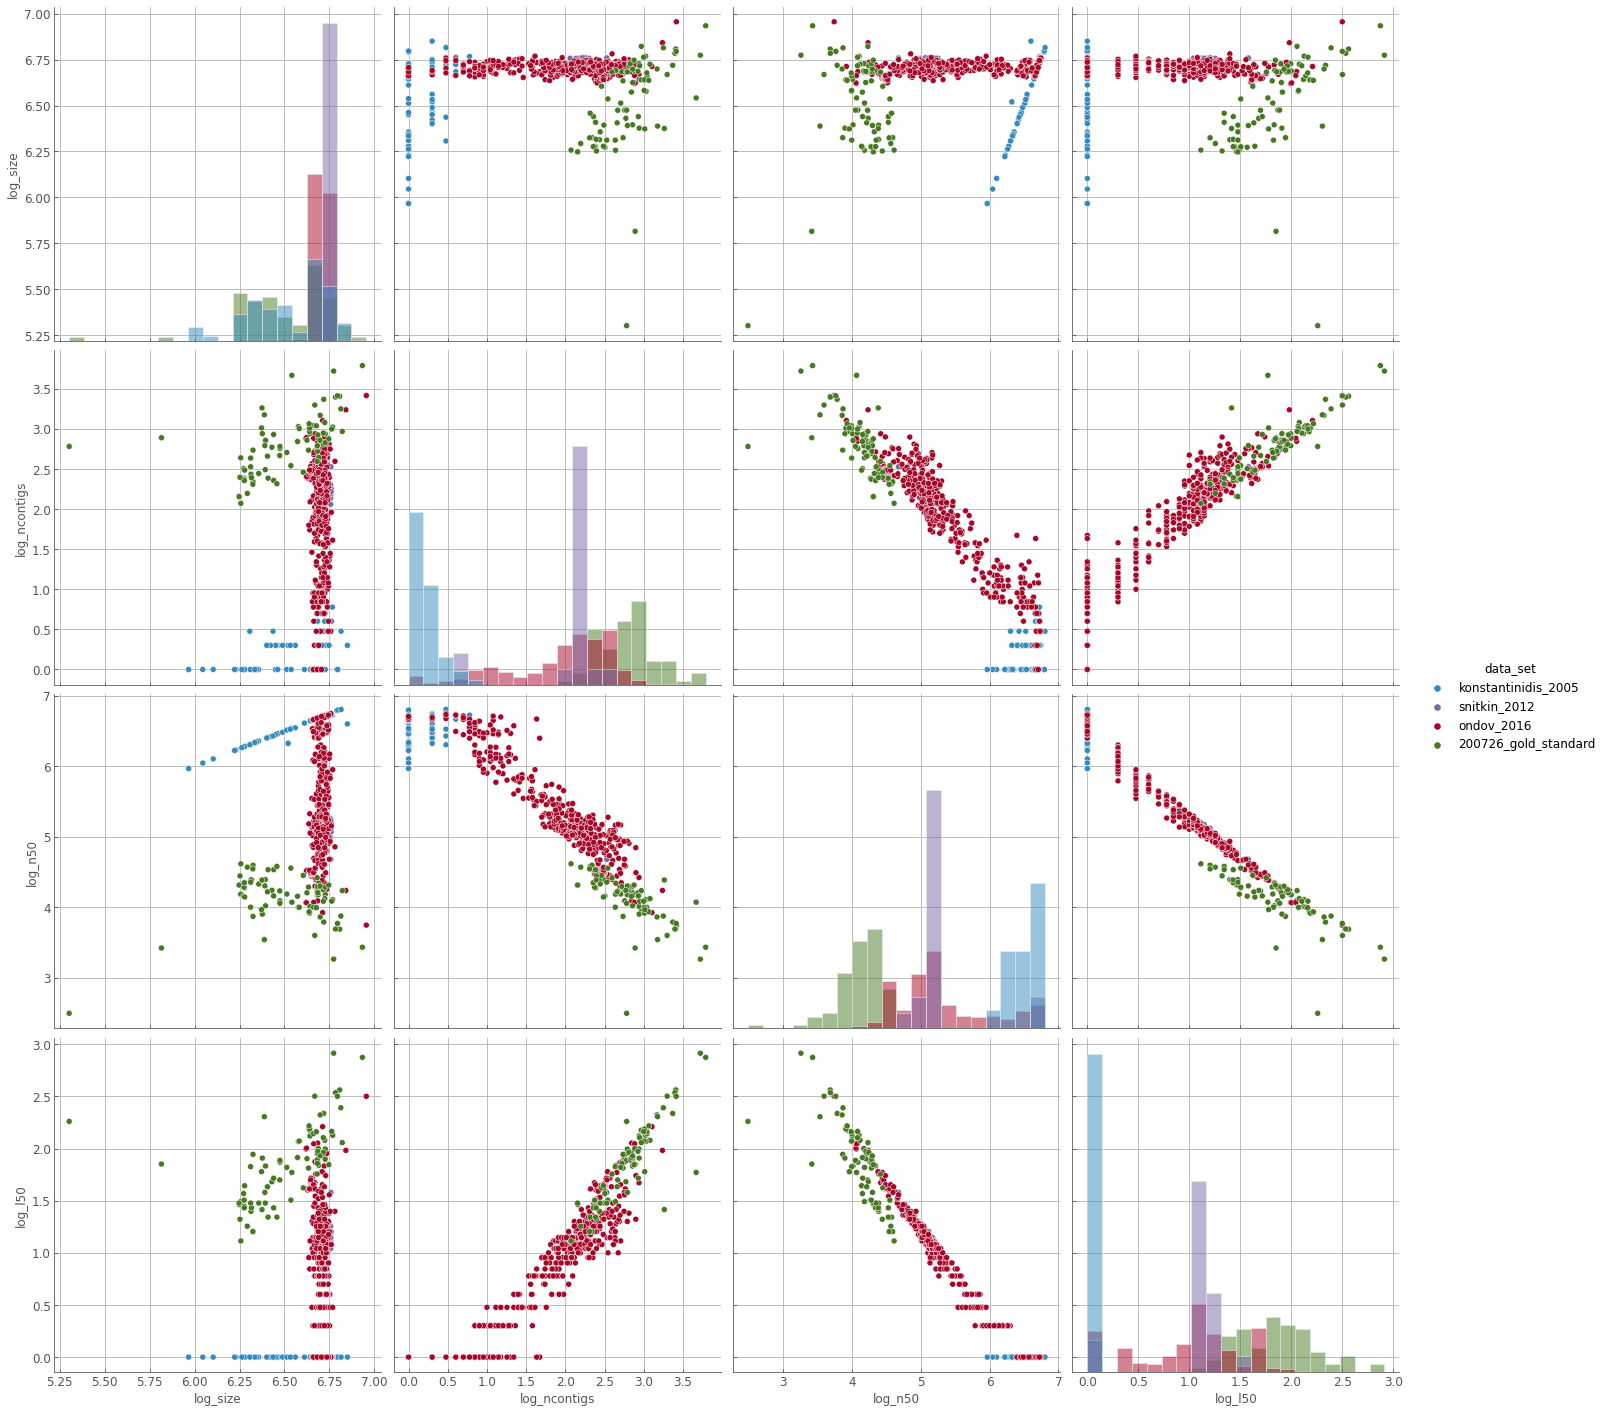

In [22]:
sns.pairplot(
    data=genomes.reset_index(),
    vars=['log_size', 'log_ncontigs', 'log_n50', 'log_l50'],
    hue='data_set',
    height=5,
    diag_kind='hist',
    diag_kws=dict(
        stat='probability',
        common_norm=False,
        bins=20,
    ),
)

### 200726 gold standard genomes

In [23]:
gs_genomes = genomes.loc['200726_gold_standard'].copy()
gs_genomes['has_prediction'] = gs_genomes['description'].str.startswith('[p')

gs_genomes[~gs_genomes['has_prediction']]

,id,description,assembly_accession,assembly_uid,size,ncontigs,n50,l50,log_size,log_ncontigs,log_n50,log_l50,has_prediction
ds_index,,,,,,,,,,,,,
39,18AC0018936-1_S12,[closest] Staphylococcus epidermidis,NaN,NaN,200285,604,311,182,5.301648,2.781037,2.492760,2.260071,False
42,18AC0018937-BAP_S11,[closest] Proteus mirabilis,NaN,NaN,3779675,1069,9911,117,6.577454,3.028978,3.996117,2.068186,False
48,19AC0002349B1_S10,[closest] Clostridium perfringens,NaN,NaN,653490,775,2628,71,5.815239,2.889302,3.419625,1.851258,False
58,19AC0011210_S5,[closest] Ureaplasma urealyticum,NaN,NaN,1874280,319,14297,37,6.272834,2.503791,4.155245,1.568202,False


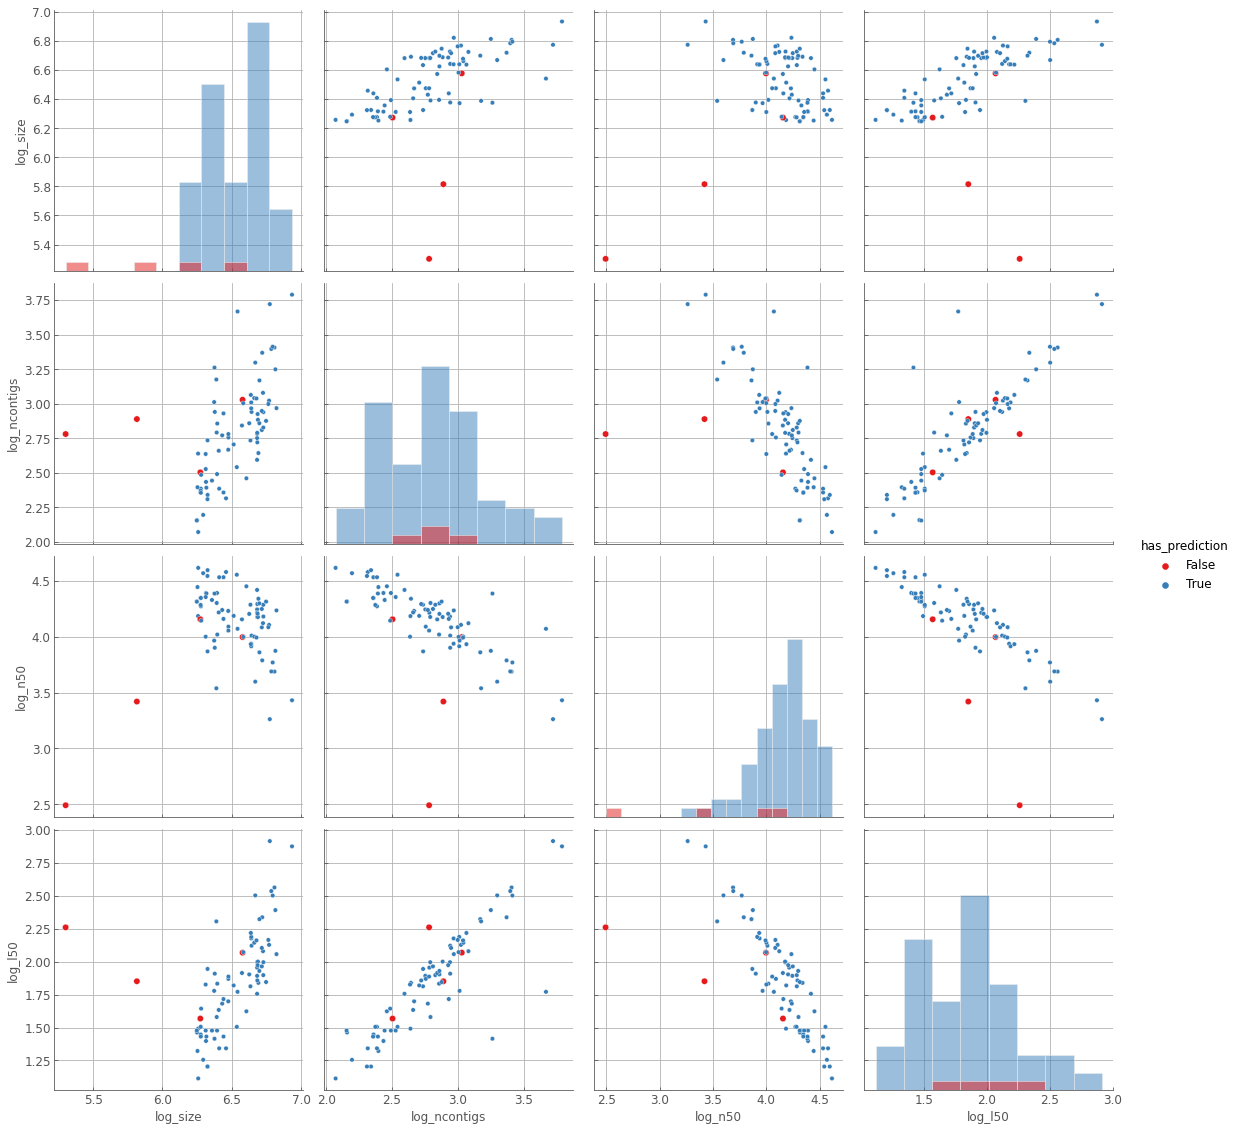

In [24]:
sns.pairplot(
    data=gs_genomes.reset_index(),
    vars=['log_size', 'log_ncontigs', 'log_n50', 'log_l50'],
    hue='has_prediction',
    palette='Set1',
    plot_kws=dict(s=np.where(gs_genomes['has_prediction'], 20, 40)),
    height=4,
    diag_kind='hist',
    diag_kws=dict(stat='probability'),
)